In [3]:
# !ulimit -v 80000
!ulimit -v 8000000

In [8]:
import os

import cv2

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [57]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

mnist_dataloader = DataLoader(mnist_trainset, batch_size=4)
dataloader_size = len(mnist_dataloader)

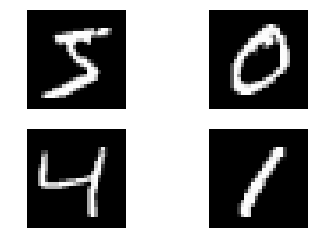

In [54]:
images, _ = next(iter(mnist_dataloader))

for i, image in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0, :, :], cmap='gray')
    plt.axis('off')
plt.show()

In [48]:
class Generator(nn.Module):
    def __init__(self, input_size, image_size=128, n_channels=3):
        super(Generator, self).__init__()
        
        self.input_size = input_size
        self.init_size = np.ceil(image_size / 8).astype(int)
        
        self.fc1 = nn.Linear(self.input_size, 128 * self.init_size * self.init_size)
        
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64)            
        )
        
        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.ConvTranspose2d(32, n_channels, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, z):
        hidden = self.fc1(z)
        hidden = hidden.view(-1, 128, self.init_size, self.init_size)
        hidden = self.conv_block1(hidden)
        hidden = self.relu(hidden)
        
        hidden = self.conv_block2(hidden)
        hidden = self.relu(hidden)
        
        hidden = self.conv_block3(hidden)
        output = self.tanh(hidden)
        
        return output

In [49]:
class Discriminator(nn.Module):
    def __init__(self, image_size, n_channels=3):
        super(Discriminator, self).__init__()
        
        self.image_size = image_size
        self.fc_size = np.ceil(self.image_size / 8).astype(int)
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(32)            
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * self.fc_size * self.fc_size, 256),
            nn.Linear(256, 1)
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.relu(x)
        
        x = self.conv_block2(x)
        x = self.relu(x)
        
        x = self.conv_block3(x)
        x = self.relu(x)
        
        x = x.view(-1, 128 * self.fc_size * self.fc_size)
        
        output = self.fc(x)
        
        return output

In [50]:
n_epochs = 100
generator_lr = 2e-6
discriminator_lr = 1e-4

generator = Generator(100, 28, n_channels=1)
discriminator = Discriminator(28, n_channels=1)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=generator_lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr)

adversarial_loss = torch.nn.BCEWithLogitsLoss()

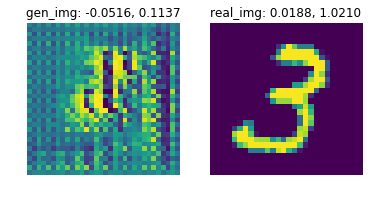

[Epoch 0/100] [D loss: 0.000000] [G loss: 20.579609]


In [ ]:
d_history = []
g_history = []
for epoch in range(n_epochs):
    running_d_loss = 0
    running_g_loss = 0
    for images, _ in mnist_dataloader:
        real = Variable(torch.ones(images.shape[0], 1), requires_grad=False)
        fake = Variable(torch.zeros(images.shape[0], 1), requires_grad=False)

        z = Variable(torch.Tensor(np.random.randn(images.shape[0], 100)))
        generated_images = generator(z)

        g_loss = adversarial_loss(discriminator(generated_images), real)

        g_loss.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        real_loss = adversarial_loss(discriminator(images), real)
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()
        
        running_d_loss += d_loss
        running_g_loss += g_loss

        
    running_d_loss /= dataloader_size
    running_g_loss /= dataloader_size
    
    d_history.append(running_d_loss)
    g_history.append(running_g_loss)
    
    real_img = images[0, 0].data.numpy()
    gen_img = generated_images[0, 0].data.numpy()
    
    plt.subplot(1, 2, 1)
    plt.title('gen_img: {:.4f}, {:.4f}'.format(gen_img.mean(), gen_img.var()))
    plt.imshow(gen_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('real_img: {:.4f}, {:.4f}'.format(real_img.mean(), real_img.var()))
    plt.imshow(real_img)
    plt.axis('off')
    plt.show()
    print ("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs,
                                                    running_d_loss, running_g_loss))